In [1]:
from generateMazeMaps import generate_random_maze
import pickle
import os
from os import path as osp
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import torch
import json
from transformer import Models

In [2]:
def pix2geom(pos, res=0.05, length=24):
    """
    Converts pixel co-ordinates to geometrical positions. 
    :param pos: The (x,y) pixel co-ordinates.
    :param res: The distance represented by each pixel.
    :param length: The length of the map in meters.
    :returns (float, float): The associated eucledian co-ordinates.
    """
    return (pos[0]*res, length-pos[1]*res)

def geom2pix(pos, res=0.05, size=(480, 480)):
    """
    Convert geometrical position to pixel co-ordinates. The origin 
    is assumed to be at [image_size[0]-1, 0].
    :param pos: The (x,y) geometric co-ordinates.
    :param res: The distance represented by each pixel.
    :param size: The size of the map image
    :returns (int, int): The associated pixel co-ordinates.
    NOTE: The Pixel co-ordinates are represented as follows:
    (0,0)------ X ----------->|
    |                         |  
    |                         |  
    |                         |  
    |                         |  
    Y                         |
    |                         |
    |                         |  
    v                         |  
    ---------------------------  
    """
    return (int(np.floor(pos[0]/res)), int(size[0]-1-np.floor(pos[1]/res)))

# Generate start and end points

{'path': array([[18.1       ,  7.2       ],
       [11.49801481,  7.17237864],
       [11.47926073,  6.67273048],
       [11.48011996,  6.17273122],
       [11.15604422,  5.7919755 ],
       [11.08149358,  5.29756454],
       [10.79685436,  4.88649214],
       [10.34757225,  5.10591317],
       [ 9.97204684,  4.77579097],
       [ 9.56348265,  5.06401883],
       [ 9.17094226,  5.37371553],
       [ 8.70278193,  5.54928861],
       [ 8.21818469,  5.67243694],
       [ 7.71895959,  5.70026319],
       [ 7.23531718,  5.57341673],
       [ 6.78803522,  5.34994671],
       [ 6.28904196,  5.31823356],
       [ 5.90469257,  4.99842809],
       [ 5.58135859,  4.61704227],
       [ 5.56412066,  4.11733951],
       [ 5.544903  ,  3.61770896],
       [ 5.25338616,  3.21148498],
       [ 4.7575164 ,  3.14735089],
       [ 4.27267085,  3.26951797],
       [ 4.03254712,  2.83095145],
       [ 3.55      ,  2.7       ]]), 'path_interpolated': array([[18.1       ,  7.2       ],
       [17.7525271 ,  7

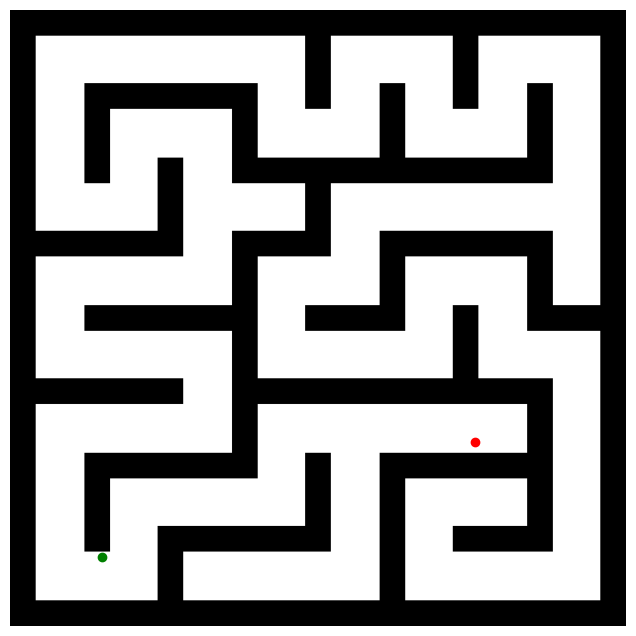

In [3]:
new_file_path = "new_maze/train/env000000"
new_data = pickle.load(open(osp.join(new_file_path, f'path_{0}.p'), 'rb'))
print(new_data)
new_path = new_data['path_interpolated']
new_goal_pos = geom2pix(new_path[0, :])
new_start_pos = geom2pix(new_path[-1, :])
new_MazeMap = io.imread(osp.join(new_file_path, f'map_{0}.png'), as_gray=True)
new_fig, new_ax = plt.subplots(figsize=(8, 8))
new_ax.imshow(new_MazeMap, cmap='gray')
new_ax.scatter(new_goal_pos[0], new_goal_pos[1], color='r', zorder=3)
new_ax.scatter(new_start_pos[0], new_start_pos[1], color='g', zorder=3)
new_ax.axis('off')

print(new_start_pos[0], new_start_pos[1], new_goal_pos[0], new_goal_pos[1])

71 426 362 336


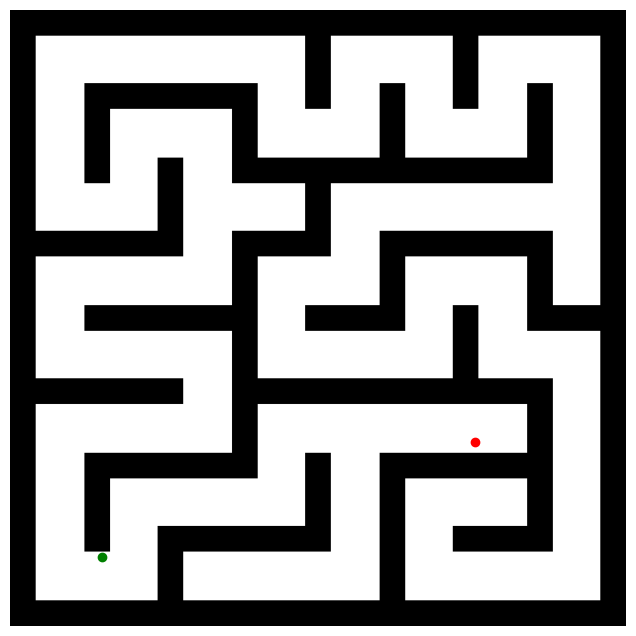

In [7]:
file_path = "new_maze/train/env000000"
data = pickle.load(open(osp.join(file_path, f'path_{0}.p'), 'rb'))
path = data['path_interpolated']
goal_pos = geom2pix(path[0, :])
start_pos = geom2pix(path[-1, :])

MazeMap = io.imread(osp.join(file_path, f'map_{0}.png'), as_gray=True)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(MazeMap, cmap='gray')
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.axis('off')

print(start_pos[0], start_pos[1], goal_pos[0], goal_pos[1])

## Load Trained Model

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

modelPath = 'checkpoint.pt'
checkpoint = torch.load("checkpoint.pt")
modelFile = 'training_results/model_params.json'
model_param = json.load(open(modelFile))
transformer = Models.Transformer(**model_param)
_ = transformer.to(device)
transformer.load_state_dict(checkpoint['model_state_dict']) 
_ = transformer.eval()

In [18]:
from eval_model import get_patch

patch_map, predProb = get_patch(transformer, start_pos, goal_pos, MazeMap)



/home/hice1/imehta34/miniconda3/envs/custom/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


(-0.5, 479.5, 479.5, -0.5)

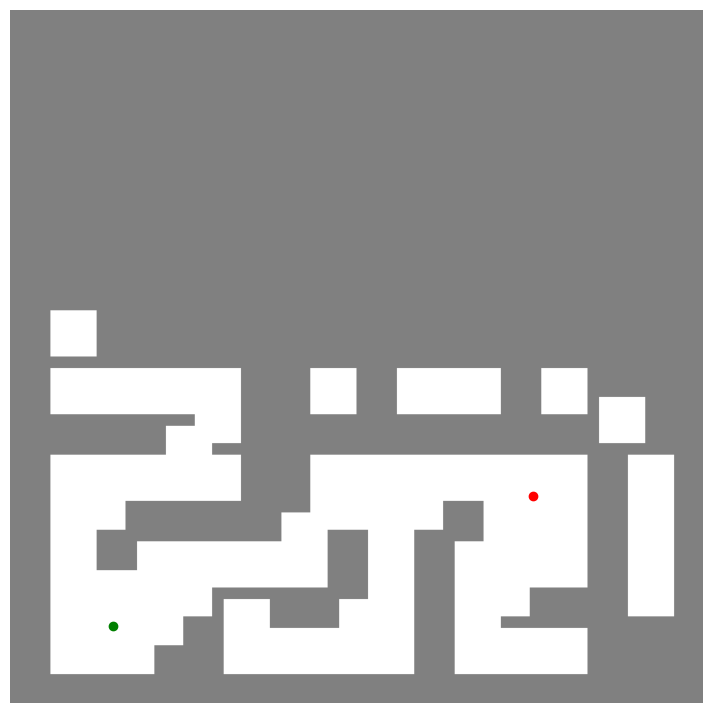

In [20]:
fig, ax = plt.subplots(figsize=(9, 9))

# ax.imshow(MazeMap, cmap='gray')
ax.imshow(patch_map, cmap='gray', alpha=0.5)
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.axis('off')

# Create ground truth patches

(-0.5, 479.5, 479.5, -0.5)

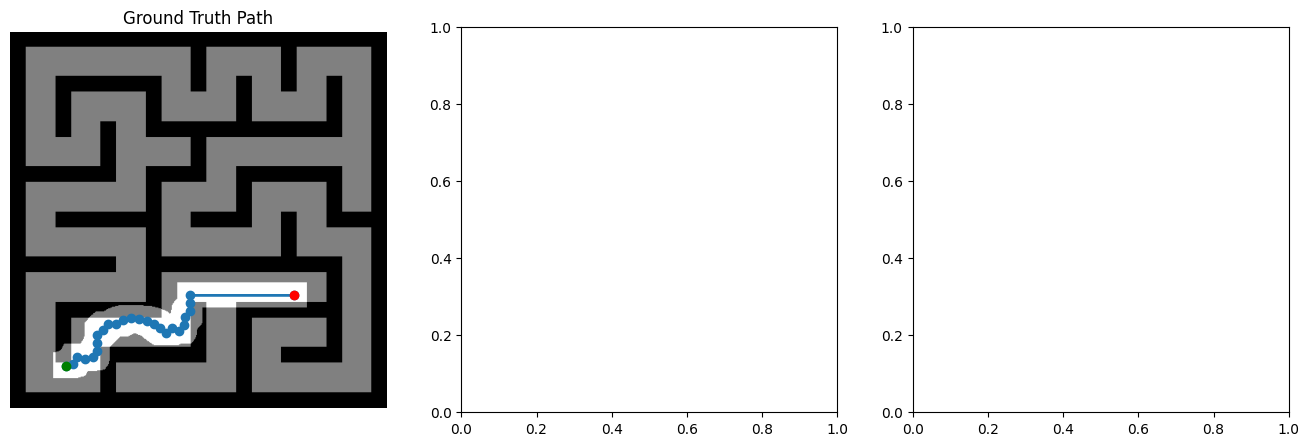

In [9]:
pathPix = [geom2pix(pos) for pos in path]

uniqueId = []
for pos in pathPix:
    if pos not in uniqueId:
        uniqueId.append(pos)
pathPixelPos = np.array([geom2pix(pos) for pos in data['path']])# Generate Patch Maps
truePatchMap = np.zeros_like(MazeMap)
map_size = MazeMap.shape
receptive_field = 32
for pos in uniqueId:
    goal_start_x = max(0, pos[0]- receptive_field//2)
    goal_start_y = max(0, pos[1]- receptive_field//2)
    goal_end_x = min(map_size[0], pos[0]+ receptive_field//2)
    goal_end_y = min(map_size[1], pos[1]+ receptive_field//2)
    truePatchMap[goal_start_y:goal_end_y, goal_start_x:goal_end_x] = 1.0

fig, ax = plt.subplots(1, 3, figsize=(16.5,5), dpi=100)
ax[0].set_title('Ground Truth Path')
ax[0].imshow(MazeMap, cmap='gray')
#ground Truth Cloud
ax[0].imshow(truePatchMap, cmap='gray', alpha=0.5)
#Ground Truth Path
ax[0].plot(pathPixelPos[:,0], pathPixelPos[:,1], marker='o', linewidth=2)
ax[0].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax[0].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax[0].axis('off')